In [24]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from hyperopt import hp, STATUS_OK, fmin, tpe, Trials
from hyperopt.pyll import scope
import numpy as np
import pandas as pd
import time
import os

In [25]:
MODEL_NAME = 'model_2025_04_10-17_39_24.keras'
# MODEL_NAME = None
DATA_PATH = 'assets/crypto-data.csv'
SEQUENCE_LENGTH = 30
TEST_DAYS = 7
MODELS_DIR = os.path.join(os.curdir, "assets/models")

# Wczytanie danych

In [26]:
df = pd.read_csv(DATA_PATH)
df['real-daily-trend'] = df['monthly-btc-trend'] * df['daily-btc-trend'] / 100

In [27]:
df.head()

,date,open,high,low,close,volume,avg-block-size,n-transactions-per-block,n-payments-per-block,transactions-per-second,blocks-size,hash-rate,difficulty,monthly-btc-trend,daily-btc-trend,real-daily-trend
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,1.029120e+10,1.043383,1549.724359,3152.608974,2.630903,150110.786114,1.497558e+07,1.922581e+12,81,45,36.45
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,1.684660e+10,1.041368,1994.035088,4026.590643,3.848264,150273.540487,1.641554e+07,1.931136e+12,81,53,42.93
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,1.687190e+10,1.065513,2522.057325,4718.490446,4.486979,150451.629839,1.507158e+07,1.931136e+12,81,56,45.36
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,2.178320e+10,1.065833,2529.809524,5122.785714,5.275347,150618.904617,1.612755e+07,1.931136e+12,81,54,43.74
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,2.384090e+10,1.067636,2396.552448,5124.125874,4.563021,150797.951213,1.372762e+07,1.931136e+12,81,48,38.88


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2647 entries, 0 to 2646
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      2647 non-null   object 
 1   open                      2647 non-null   float64
 2   high                      2647 non-null   float64
 3   low                       2647 non-null   float64
 4   close                     2647 non-null   float64
 5   volume                    2647 non-null   float64
 6   avg-block-size            2647 non-null   float64
 7   n-transactions-per-block  2647 non-null   float64
 8   n-payments-per-block      2647 non-null   float64
 9   transactions-per-second   2647 non-null   float64
 10  blocks-size               2647 non-null   float64
 11  hash-rate                 2647 non-null   float64
 12  difficulty                2647 non-null   float64
 13  monthly-btc-trend         2647 non-null   int64  
 14  daily-bt

In [29]:
df.describe()

,open,high,low,close,volume,avg-block-size,n-transactions-per-block,n-payments-per-block,transactions-per-second,blocks-size,hash-rate,difficulty,monthly-btc-trend,daily-btc-trend,real-daily-trend
count,2647.000000,2647.000000,2647.000000,2647.000000,2.647000e+03,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2.647000e+03,2.647000e+03,2647.000000,2647.000000,2647.000000
mean,30281.863739,30941.148166,29581.103916,30306.100149,2.754548e+10,1.289727,2292.424912,4699.346216,3.686948,370809.060640,2.484452e+08,3.421812e+13,35.455988,64.631281,21.651632
std,24791.697635,25312.633506,24235.637231,24808.859147,2.004631e+10,0.327854,826.617653,1613.591151,1.237448,143268.936291,2.243894e+08,3.066762e+13,18.909865,18.560845,11.469697
min,3236.274658,3275.377930,3191.303467,3236.761719,2.923670e+09,0.431452,834.129630,1520.088889,1.554340,150110.786114,1.372762e+07,1.922581e+12,12.000000,17.000000,6.200000
25%,9165.169434,9308.080078,8976.270508,9167.385742,1.414231e+10,1.054804,1773.363020,3540.249883,2.961892,245931.117534,8.885100e+07,1.287580e+13,20.000000,52.000000,13.320000
50%,23240.203125,23739.138672,22861.558594,23264.291016,2.439725e+10,1.260745,2107.352000,4422.271523,3.420660,359529.874091,1.569433e+08,2.145523e+13,30.000000,66.000000,19.500000
75%,44960.826172,46619.900391,43783.865234,45050.421875,3.604767e+10,1.584134,2492.410661,5572.578759,3.965799,486896.703422,3.617916e+08,5.064621e+13,44.000000,78.000000,25.705000
max,106147.296875,109114.882812,105291.734375,106146.265625,3.509679e+11,2.524785,5517.916667,10476.342466,10.855556,648806.373469,9.888068e+08,1.141673e+14,100.000000,100.000000,100.000000


# Przygotowanie danych

In [30]:
df = df.drop(columns=['date'])
df = df.drop(columns=['monthly-btc-trend'])
df = df.drop(columns=['daily-btc-trend'])

In [31]:
n_samples = len(df) - SEQUENCE_LENGTH
n_features = df.shape[1]

In [32]:
X_full = np.zeros((n_samples, SEQUENCE_LENGTH, n_features), dtype=np.float64)
y_full = np.zeros((n_samples, 3), dtype=np.float64) 

for i in range(n_samples):
    X_full[i] = df.iloc[i:i+SEQUENCE_LENGTH].values
    y_full[i] = df.iloc[i+SEQUENCE_LENGTH][['high', 'low', 'close']].values

In [33]:
print(f"X={X_full.shape}")
print(f"y={y_full.shape}")

X=(2617, 30, 13)
y=(2617, 3)


Podzielmy dane na:
- train (70%)
- validation (20%)
- test (10%)

In [34]:
X_temp, X_test = X_full[:-(TEST_DAYS + 1)], X_full[-(TEST_DAYS + 1):]
y_temp, y_test = y_full[:-(TEST_DAYS + 1)], y_full[-(TEST_DAYS + 1):]
X_val, X_train, y_val, y_train = train_test_split(X_temp, y_temp, test_size=0.9, shuffle=True)

print(f"Test:       X={X_test.shape},  y={y_test.shape}")
print(f"Train:      X={X_train.shape}, y={y_train.shape}")
print(f"Validation: X={X_val.shape},   y={y_val.shape}")

Test:       X=(8, 30, 13),  y=(8, 3)
Train:      X=(2349, 30, 13), y=(2349, 3)
Validation: X=(260, 30, 13),   y=(260, 3)


# Model podstawowy


## Definiujemy model

In [35]:
def build_basic_dense_model(hparams):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    for i in range(hparams['hidden_layers']):
        units = hparams[f'units_layer{i}']
        model.add(keras.layers.Dense(units))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(hparams['activation']))  

    model.add(keras.layers.Dense(3))

    optimizer = keras.optimizers.get(hparams['optimizer'])
    optimizer.learning_rate = hparams['lr']

    model.compile(optimizer=optimizer, loss='huber')
    return model

## Przestrzeń hiperparametrów

In [36]:
space = {
    'hidden_layers': hp.randint('num_layers', 3, 5),
    'units_layer0': hp.randint('units_layer0', 64, 1024),
    'units_layer1': hp.randint('units_layer1', 64, 1024),
    'units_layer2': hp.randint('units_layer2', 64, 1024),
    'units_layer3': hp.randint('units_layer3', 64, 1024), 
    'units_layer4': hp.randint('units_layer4', 64, 1024), 
    'activation': hp.choice('activation', ['relu', 'elu']),
    'optimizer': hp.choice('optimizer', ['adam', 'nadam', 'rmsprop']),
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-2)),
    'batch_size': scope.int(hp.quniform('batch_size', 32, 256, 32)),
}

## Szukamy najlepszego

In [37]:
def objective(hparams):
    model = build_basic_dense_model(hparams)

    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=hparams['batch_size'],
    )

    val_loss = model.evaluate(X_val, y_val, verbose=0)

    return {
        'loss': val_loss,
        'status': STATUS_OK,
        'model': model,
    }

In [38]:
if MODEL_NAME is None:
    trials = Trials()

    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=70,
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    print("Najlepsze hiperparametry:")
    print(best)

## Budujemy wybrany już najlepszy model większą liczbą epok

In [39]:
model = None

if MODEL_NAME is None:
    model = trials.best_trial['result']['model']

    model.summary()
else:
    model = keras.models.load_model(f"{MODELS_DIR}/{MODEL_NAME}")

In [40]:
model.layers

[<Flatten name=flatten_52, built=True>,
 <Dense name=dense_194, built=True>,
 <BatchNormalization name=batch_normalization_144, built=True>,
 <Activation name=activation_144, built=True>,
 <Dense name=dense_195, built=True>]

In [41]:
if MODEL_NAME is None:
    optimizer = tf.keras.optimizers.Adam()

    model.compile(optimizer=optimizer, loss='huber')

In [42]:
model_id = time.strftime("model_%Y_%m_%d-%H_%M_%S")
model_path = f"{MODELS_DIR}/{model_id}.keras"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)

class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nwalidacja/uczenie: {:.2f}".format(logs["val_loss"] / logs["loss"]))

print_val_train_ratio_cb = PrintValTrainRatioCallback()

In [43]:
history = None
if MODEL_NAME is None:
    history = model.fit(
        X_train,
        y_train,
        epochs=70,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint_cb, early_stopping_cb, print_val_train_ratio_cb]
    )

In [44]:
if history is not None:
    pd.DataFrame(history.history).plot(figsize=(8, 5))

    # Ustawienie wyglądu wykresu
    plt.grid(True)
    plt.title("Krzywa uczenia: Średnia funkcja straty (loss) oraz val_loss dla zbioru walidacyjnego")
    plt.xlabel("Epoki")
    plt.ylabel("Funkcja straty")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


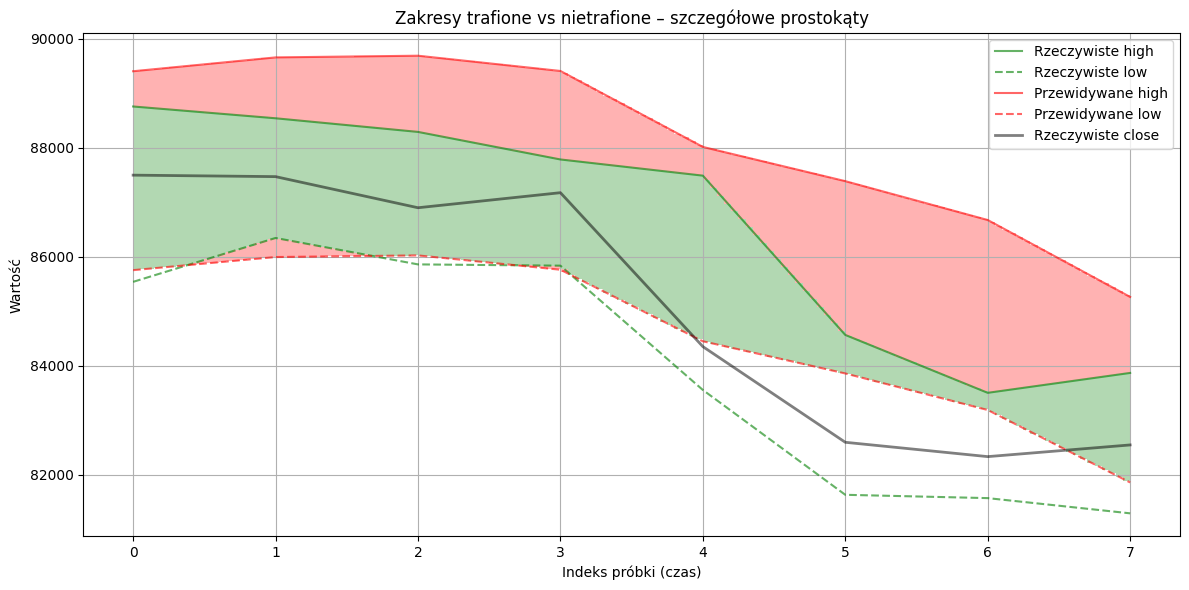

In [45]:
predictions = model.predict(X_test)

n_points = len(y_test)
x_main = np.arange(n_points)

real_high = y_test[:, 0]
real_low = y_test[:, 1]
real_close = y_test[:, 2]
pred_high = predictions[:, 0]
pred_low = predictions[:, 1]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_main, real_high, label='Rzeczywiste high', color='green', alpha=0.6)
ax.plot(x_main, real_low, label='Rzeczywiste low', color='green', linestyle='--', alpha=0.6)

ax.plot(x_main, pred_high, label='Przewidywane high', color='red', alpha=0.6)
ax.plot(x_main, pred_low, label='Przewidywane low', color='red', linestyle='--', alpha=0.6)

ax.plot(x_main, real_close, label='Rzeczywiste close', color='black', linewidth=2, alpha=0.5)

# Parametr: liczba podziałów dla każdego przedziału między punktami.
res = 20  # im wyższa wartość, tym więcej małych prostokątów

for i in range(n_points - 1):
    x0 = x_main[i]
    x1 = x_main[i+1]
    dx = (x1 - x0) / res  # szerokość małego prostokąta
    
    for j in range(res):
        t = (j + 0.5) / res
        
        ph = pred_high[i] + (pred_high[i+1] - pred_high[i]) * t
        pl = pred_low[i]  + (pred_low[i+1]  - pred_low[i])  * t
        rh = real_high[i] + (real_high[i+1] - real_high[i]) * t
        rl = real_low[i]  + (real_low[i+1]  - real_low[i])  * t
        
        x_rect = x0 + j * dx
        
        green_top = min(ph, rh)
        green_bottom = max(pl, rl)
        
        # Sprawdzenie, czy w tym subprzedziale jest jakieś przecięcie
        if green_top > green_bottom:
            # Rysujemy zielony prostokąt – fragment, gdzie predykcja pokrywa się z zakresem rzeczywistym.
            rect_green = Rectangle(
                (x_rect, green_bottom), dx, green_top - green_bottom,
                facecolor='green', alpha=0.3
            )
            ax.add_patch(rect_green)
            
            # Górny fragment (czerwony) – jeśli górna część predykcji wykracza poza przecięcie
            if ph > green_top:
                rect_red_upper = Rectangle(
                    (x_rect, green_top), dx, ph - green_top,
                    facecolor='red', alpha=0.3
                )
                ax.add_patch(rect_red_upper)
            # Dolny fragment (czerwony) – jeśli dolna część predykcji wykracza poniżej przecięcia
            if pl < green_bottom:
                rect_red_lower = Rectangle(
                    (x_rect, pl), dx, green_bottom - pl,
                    facecolor='red', alpha=0.3
                )
                ax.add_patch(rect_red_lower)
        else:
            # Jeżeli nie ma przecięcia, całość przedziału predykcji rysujemy na czerwono
            rect_red = Rectangle(
                (x_rect, pl), dx, ph - pl,
                facecolor='red', alpha=0.3
            )
            ax.add_patch(rect_red)

ax.set_title("Zakresy trafione vs nietrafione – szczegółowe prostokąty")
ax.set_xlabel("Indeks próbki (czas)")
ax.set_ylabel("Wartość")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()